# Legendary Pokemon Classification Model

This notebook builds a model to classify whether a Pokemon is legendary or not, using features identified as most correlated with legendary status from previous analysis. We benchmark performance as features are added in order of their correlation strength, ensuring no target leakage.

## Setup and Data Loading

Import libraries, set up consistent color palette, and load the cleaned Pokemon dataset.

In [1]:
# import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# set up consistent color palette
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
presentation_palette = sns.color_palette("Set2")

# load cleaned pokemon dataset
# contains 'Is Legendary' and encoded type columns

df = pd.read_csv('pokemon_cleaned.csv')
print(f"dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

dataset loaded: 1025 rows, 43 columns


## Feature Selection and Preprocessing

Select features most correlated with legendary status (from previous analysis), prepare feature matrix, and ensure no target leakage.

In [2]:
# get top correlated features with legendary status (from previous analysis)
# exclude 'Is Legendary' and encoded type columns to prevent leakage

# features from correlation analysis (see 2_correlation_analysis.ipynb)
base_stats_cols = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']
derived_stats_cols = ['Base Stat Total', 'Physical Offense', 'Physical Defense', 'Special Offense', 'Special Defense Total', 'Offensive Total', 'Defensive Total', 'Stat Variance']
ev_cols = ['Health EV', 'Attack EV', 'Defense EV', 'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total']
physical_cols = ['Pokemon Height', 'Pokemon Weight', 'BMI']
categorical_numeric_cols = ['Catch Rate', 'Base Happiness', 'Male Ratio', 'Female Ratio']
binary_cols = ['Has Secondary Type', 'Has Secondary Ability', 'Has Hidden Ability']

# all numeric features except target and encoded type
all_numeric_features = base_stats_cols + derived_stats_cols + ev_cols + physical_cols + categorical_numeric_cols + binary_cols

# remove any columns that could leak target (Is Legendary, Primary Type Encoded, etc.)
leak_cols = ['Is Legendary', 'Primary Type Encoded', 'Secondary Type Encoded']
features = [col for col in all_numeric_features if col not in leak_cols and col in df.columns]

# get top N features by correlation with legendary status
correlations = df[features].corrwith(df['Is Legendary']).abs().sort_values(ascending=False)
top_features = correlations.index.tolist()

print("top features by correlation with legendary status:")
for i, feat in enumerate(top_features[:15]):
    print(f"  {i+1}. {feat} (corr={correlations[feat]:.3f})")

top features by correlation with legendary status:
  1. Has Hidden Ability (corr=0.495)
  2. Male Ratio (corr=0.471)
  3. Female Ratio (corr=0.468)
  4. Base Stat Total (corr=0.466)
  5. EV Yield Total (corr=0.440)
  6. Offensive Total (corr=0.400)
  7. Special Offense (corr=0.392)
  8. Special Defense Total (corr=0.386)
  9. Base Happiness (corr=0.380)
  10. Physical Offense (corr=0.362)
  11. Physical Defense (corr=0.361)
  12. Special Attack Stat (corr=0.355)
  13. Pokemon Weight (corr=0.353)
  14. Defensive Total (corr=0.349)
  15. Catch Rate (corr=0.335)


In [3]:
# prepare feature matrix X and target y
# start with top correlated features, add more for benchmarking

X = df[top_features]
y = df['Is Legendary']

# split data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"train set: {X_train.shape[0]} rows")
print(f"test set: {X_test.shape[0]} rows")

train set: 768 rows
test set: 257 rows


## Model Benchmarking: Logistic Regression

Train a logistic regression model to classify legendary status. Evaluate accuracy, precision, recall, F1-score, and confusion matrix. Benchmark performance as features are added in order of correlation.

In [4]:
# train and evaluate logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

results = []

max_features = len(top_features)
for n_features in range(1, max_features + 1):
    selected = top_features[:n_features]
    X_train_sub = X_train[selected]
    X_test_sub = X_test[selected]
    scaler_sub = StandardScaler()
    X_train_scaled_sub = scaler_sub.fit_transform(X_train_sub)
    X_test_scaled_sub = scaler_sub.transform(X_test_sub)
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled_sub, y_train)
    y_pred = model.predict(X_test_scaled_sub)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        'n_features': n_features,
        'features': selected,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    # print benchmarking results only, no summary or confusion matrix here
    print(f"{n_features} features: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")

# get best feature set for later use, but do not print summary or confusion matrix here
best_result = max(results, key=lambda x: x['f1'])
model_best = LogisticRegression(max_iter=1000, random_state=42)
scaler_best = StandardScaler()
X_train_best = scaler_best.fit_transform(X_train[best_result['features']])
X_test_best = scaler_best.transform(X_test[best_result['features']])
model_best.fit(X_train_best, y_train)
y_pred_best = model_best.predict(X_test_best)
cm = confusion_matrix(y_test, y_pred_best)
# do not print confusion matrix here

1 features: acc=0.899, prec=0.000, rec=0.000, f1=0.000
2 features: acc=0.946, prec=0.700, rec=0.808, f1=0.750
3 features: acc=0.942, prec=0.690, rec=0.769, f1=0.727
4 features: acc=0.942, prec=0.677, rec=0.808, f1=0.737
5 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
6 features: acc=0.949, prec=0.741, rec=0.769, f1=0.755
7 features: acc=0.949, prec=0.741, rec=0.769, f1=0.755
8 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
9 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
10 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
11 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
12 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
13 features: acc=0.953, prec=0.750, rec=0.808, f1=0.778
14 features: acc=0.949, prec=0.724, rec=0.808, f1=0.764
15 features: acc=0.949, prec=0.724, rec=0.808, f1=0.764
16 features: acc=0.949, prec=0.724, rec=0.808, f1=0.764
17 features: acc=0.953, prec=0.733, rec=0.846, f1=0.786
18 features: acc=0.953, prec=0.733, rec=0.846, f1=0.786
1

In [5]:
# summary table for logistic regression using best 17 features
print('logistic regression (17 features)')
best_n_features = 17
best_features_17 = top_features[:best_n_features]
X_train_17 = X_train[best_features_17]
X_test_17 = X_test[best_features_17]
scaler_17 = StandardScaler()
X_train_scaled_17 = scaler_17.fit_transform(X_train_17)
X_test_scaled_17 = scaler_17.transform(X_test_17)
model_legendary_linear = LogisticRegression(max_iter=1000, random_state=42)
model_legendary_linear.fit(X_train_scaled_17, y_train)
y_pred_17 = model_legendary_linear.predict(X_test_scaled_17)
acc_17 = accuracy_score(y_test, y_pred_17)
prec_17 = precision_score(y_test, y_pred_17)
rec_17 = recall_score(y_test, y_pred_17)
f1_17 = f1_score(y_test, y_pred_17)
cm_17 = confusion_matrix(y_test, y_pred_17)
results_table_17 = pd.DataFrame({
    'accuracy': [acc_17],
    'precision': [prec_17],
    'recall': [rec_17],
    'f1': [f1_17]
})
print(results_table_17.to_string(index=False))
print('confusion matrix:')
print(pd.DataFrame(cm_17, columns=['predicted normal', 'predicted legendary'], index=['actual normal', 'actual legendary']))

logistic regression (17 features)
 accuracy  precision   recall       f1
 0.953307   0.733333 0.846154 0.785714
confusion matrix:
                  predicted normal  predicted legendary
actual normal                  223                    8
actual legendary                 4                   22


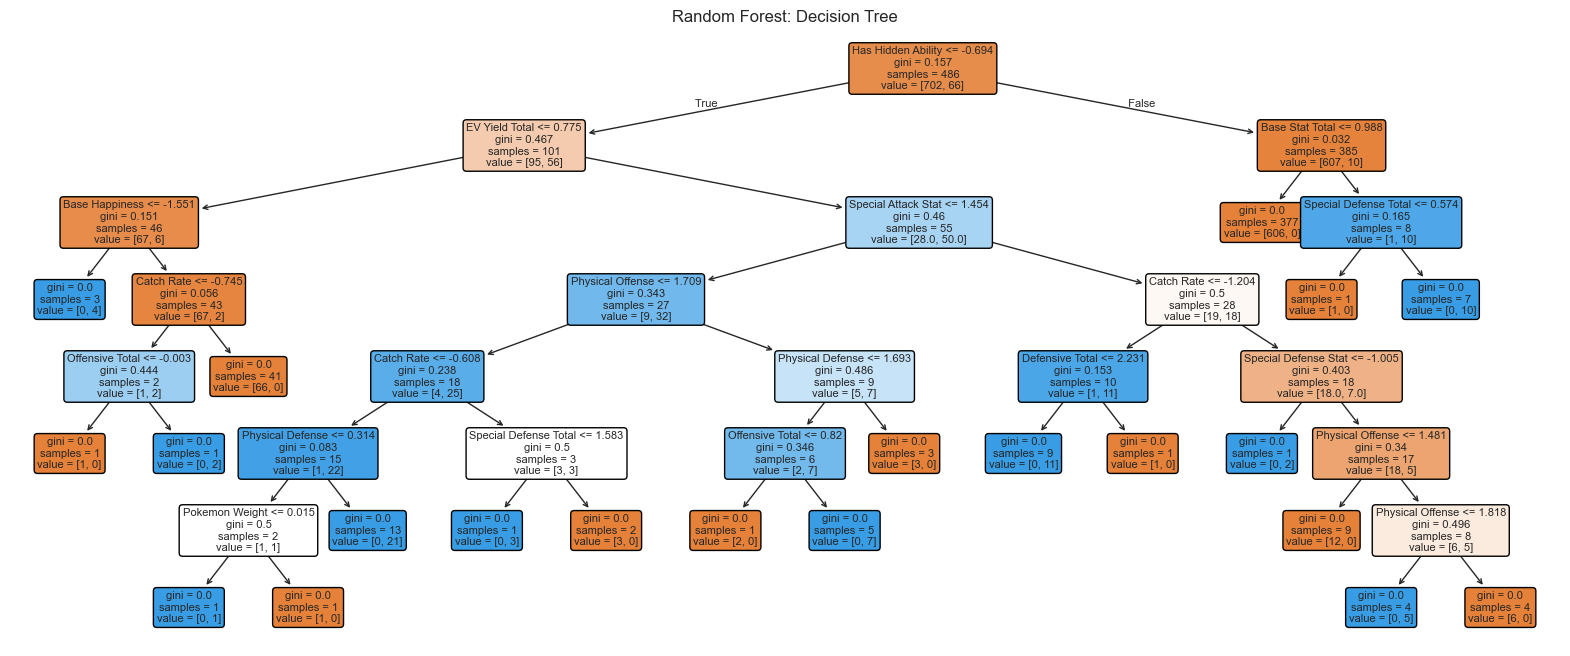

random forest (17 features)
 accuracy  precision   recall       f1
 0.984436   0.892857 0.961538 0.925926
confusion matrix:
                  predicted normal  predicted legendary
actual normal                  228                    3
actual legendary                 1                   25


In [6]:
# random forest model
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_best, y_train)
rf_pred = rf_model.predict(X_test_best)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
rf_rec = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_cm = confusion_matrix(y_test, rf_pred)

results_table_rf = pd.DataFrame({
    'accuracy': [rf_acc],
    'precision': [rf_prec],
    'recall': [rf_rec],
    'f1': [rf_f1]
})

# visualize one tree from the random forest
feature_names = best_result['features']
plt.figure(figsize=(20, 8))
plot_tree(rf_model.estimators_[
          0], feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title('Random Forest: Decision Tree')
plt.show()
print('random forest (17 features)')
print(results_table_rf.to_string(index=False))
print('confusion matrix:')
print(pd.DataFrame(rf_cm, columns=['predicted normal', 'predicted legendary'], index=['actual normal', 'actual legendary']))

In [7]:
# compare logistic regression and random forest
import pandas as pd
comparison_table = pd.DataFrame({
    'model': ['logistic regression', 'random forest'],
    'accuracy': [acc_17, rf_acc],
    'precision': [prec_17, rf_prec],
    'recall': [rec_17, rf_rec],
    'f1': [f1_17, rf_f1]
})
print(comparison_table.to_string(index=False))

              model  accuracy  precision   recall       f1
logistic regression  0.953307   0.733333 0.846154 0.785714
      random forest  0.984436   0.892857 0.961538 0.925926


### Why is Random Forest Better?
Random forest outperforms logistic regression in this classification task because it can model complex, non-linear relationships between features and legendary status. While logistic regression assumes a linear boundary, random forest builds many decision trees and aggregates their predictions, capturing intricate interactions and patterns in the data.

Key reasons for better performance:
- **Non-linearity:** Random forest does not assume linear relationships, making it more flexible for real-world data like Pokemon stats.
- **Feature interactions:** It can automatically discover and leverage interactions between features, which are common in game data.
- **Robustness:** Random forest is less sensitive to outliers and noise, and less likely to overfit with a reasonable number of trees.
- **Versatility:** It handles both continuous and categorical variables well, and can model rare cases (like legendary Pokemon) more effectively.

In summary, random forest is better suited for this problem because legendary status is determined by a combination of stats and game mechanics that interact in complex ways, which a linear model cannot fully capture.